# Chicago Car Crash Dataset

* Student name: Bonny Nichol
* Student pace: Self Paced
* Scheduled project review date/time: November 17, 2020
* Instructor name: Jeff Herman
* Blog post URL:


## Import Libraries

In [240]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

import xgboost as xgb

## Load Data

In [124]:
# load dataset
df = pd.read_csv('crashes.csv')
df.head()

CRASH_RECORD_ID     RD_NO  \
0  073682ef84ff827659552d4254ad1b98bfec24935cc9cc...  JB460108   
1  1560fb8a1e32b528fef8bfd677d2b3fc5ab37278b157fa...  JC325941   
2  c7e667807d86ff2e83da48267e1135680cad68c86eb00f...  JD150617   
3  009e9e67203442370272e1a13d6ee51a4155dac65e583d...  JA329216   
4  00e47f189660cd8ba1e85fc63061bf1d8465184393f134...  JC194776   

  CRASH_DATE_EST_I              CRASH_DATE  POSTED_SPEED_LIMIT  \
0              NaN  10/02/2018 06:30:00 PM                  10   
1              NaN  06/27/2019 04:00:00 PM                  45   
2              NaN  02/13/2020 04:30:00 PM                  30   
3              NaN  06/30/2017 04:00:00 PM                  35   
4              NaN  03/21/2019 10:50:00 PM                  30   

  TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION WEATHER_CONDITION  \
0            NO CONTROLS           NO CONTROLS             CLEAR   
1            NO CONTROLS           NO CONTROLS             CLEAR   
2            NO CONTROLS           NO CONTROLS             CLEAR   
3      STOP SIGN/FLASHER  FUNCTIONING PROPERLY             CLEAR   
4         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   

       LIGHTING_CONDITION          FIRST_CRASH_TYPE  ...  \
0                DARKNESS      PARKED MOTOR VEHICLE  ...   
1                DAYLIGHT  SIDESWIPE SAME DIRECTION  ...   
2                DAYLIGHT  SIDESWIPE SAME DIRECTION  ...   
3                DAYLIGHT                   TURNING  ...   
4  DARKNESS, LIGHTED ROAD                   TURNING  ...   

  INJURIES_NON_INCAPACITATING  INJURIES_REPORTED_NOT_EVIDENT  \
0                         0.0                            0.0   
1                         0.0                            0.0   
2                         0.0                            1.0   
3                         0.0                            0.0   
4                         0.0                            0.0   

  INJURIES_NO_INDICATION INJURIES_UNKNOWN CRASH_HOUR CRASH_DAY_OF_WEEK  \
0                    1.0              0.0         18                 3   
1                    2.0              0.0         16                 5   
2                    2.0              0.0         16                 5   
3                    3.0              0.0         16                 6   
4                    2.0              0.0         22                 5   

  CRASH_MONTH   LATITUDE  LONGITUDE                                  LOCATION  
0          10        NaN        NaN                                       NaN  
1           6        NaN        NaN                                       NaN  
2           2        NaN        NaN                                       NaN  
3           6  41.741804 -87.740954  POINT (-87.740953581987 41.741803598989)  
4           3  41.741804 -87.740954  POINT (-87.740953581987 41.741803598989)  

[5 rows x 49 columns]

## Data Exploration

We can quickly access that the dataset contains 453873 rows of data with 49 columns. This is probably too many features for our model later so we will want to access how much data is missing in these columns and how applicable they are to the model.

In [103]:
# Shape of dataset
df.shape

(453873, 49)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453873 entries, 0 to 453872
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                453873 non-null  object 
 1   RD_NO                          450376 non-null  object 
 2   CRASH_DATE_EST_I               33749 non-null   object 
 3   CRASH_DATE                     453873 non-null  object 
 4   POSTED_SPEED_LIMIT             453873 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         453873 non-null  object 
 6   DEVICE_CONDITION               453873 non-null  object 
 7   WEATHER_CONDITION              453873 non-null  object 
 8   LIGHTING_CONDITION             453873 non-null  object 
 9   FIRST_CRASH_TYPE               453873 non-null  object 
 10  TRAFFICWAY_TYPE                453873 non-null  object 
 11  LANE_CNT                       198959 non-null  float64
 12  ALIGNMENT                     

In [125]:
df = df.dropna(axis=0, subset=['INJURIES_FATAL'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452981 entries, 0 to 453872
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                452981 non-null  object 
 1   RD_NO                          449489 non-null  object 
 2   CRASH_DATE_EST_I               33566 non-null   object 
 3   CRASH_DATE                     452981 non-null  object 
 4   POSTED_SPEED_LIMIT             452981 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         452981 non-null  object 
 6   DEVICE_CONDITION               452981 non-null  object 
 7   WEATHER_CONDITION              452981 non-null  object 
 8   LIGHTING_CONDITION             452981 non-null  object 
 9   FIRST_CRASH_TYPE               452981 non-null  object 
 10  TRAFFICWAY_TYPE                452981 non-null  object 
 11  LANE_CNT                       198607 non-null  float64
 12  ALIGNMENT                     

In [106]:
#A heatmap of the missing values visually shows the data that is missing
#sns.heatmap(df.isnull())
#plt.show()

In [107]:
df['INJURIES_FATAL'].value_counts()

0.0    452545
1.0       405
2.0        25
3.0         5
4.0         1
Name: INJURIES_FATAL, dtype: int64

We can see there are 5 different types of crash under the "INJURIES_FATAL" column.<br><br>
0.0 - Crash was not fatal<br>
1.0 - One person was killed<br>
2.0 - Two people were killed<br>
3.0 - Three people were killed<br>
4.0 - Four people were killed<br><br>
Because a crash is a fatal crash whether one person or 4 people die in it, I will group these into two categories, 0 - not fatal, 1 - fatal

In [141]:
df['fatal'] = df['INJURIES_FATAL'].map(lambda x: 0 if x == 0 else 1)
df['fatal']
fatal = df['fatal']
fatal

0         0
1         0
2         0
3         0
4         0
         ..
453868    0
453869    0
453870    0
453871    0
453872    0
Name: fatal, Length: 452981, dtype: int64

In [127]:
df.columns

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LA

In [110]:
# df['WEATHER_CONDITION'].value_counts()

CLEAR                       359882
RAIN                         41023
UNKNOWN                      19417
SNOW                         15724
CLOUDY/OVERCAST              13521
OTHER                         1388
FOG/SMOKE/HAZE                 798
SLEET/HAIL                     656
FREEZING RAIN/DRIZZLE          426
SEVERE CROSS WIND GATE          82
BLOWING SNOW                    62
BLOWING SAND, SOIL, DIRT         2
Name: WEATHER_CONDITION, dtype: int64

In [111]:
#crashdata = df.drop(['DATE_POLICE_NOTIFIED','POSTED_SPEED_LIMIT','CRASH_DATE','RD_NO','CRASH_RECORD_ID','CRASH_DATE_EST_I', 'LANE_CNT', 'INTERSECTION_RELATED_I', 
#                     'NOT_RIGHT_OF_WAY_I', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE',
#        'WORKERS_PRESENT_I', 'INJURIES_UNKNOWN'], axis=1)
#crashdata.columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5c9144b70>,
      dtype=object)

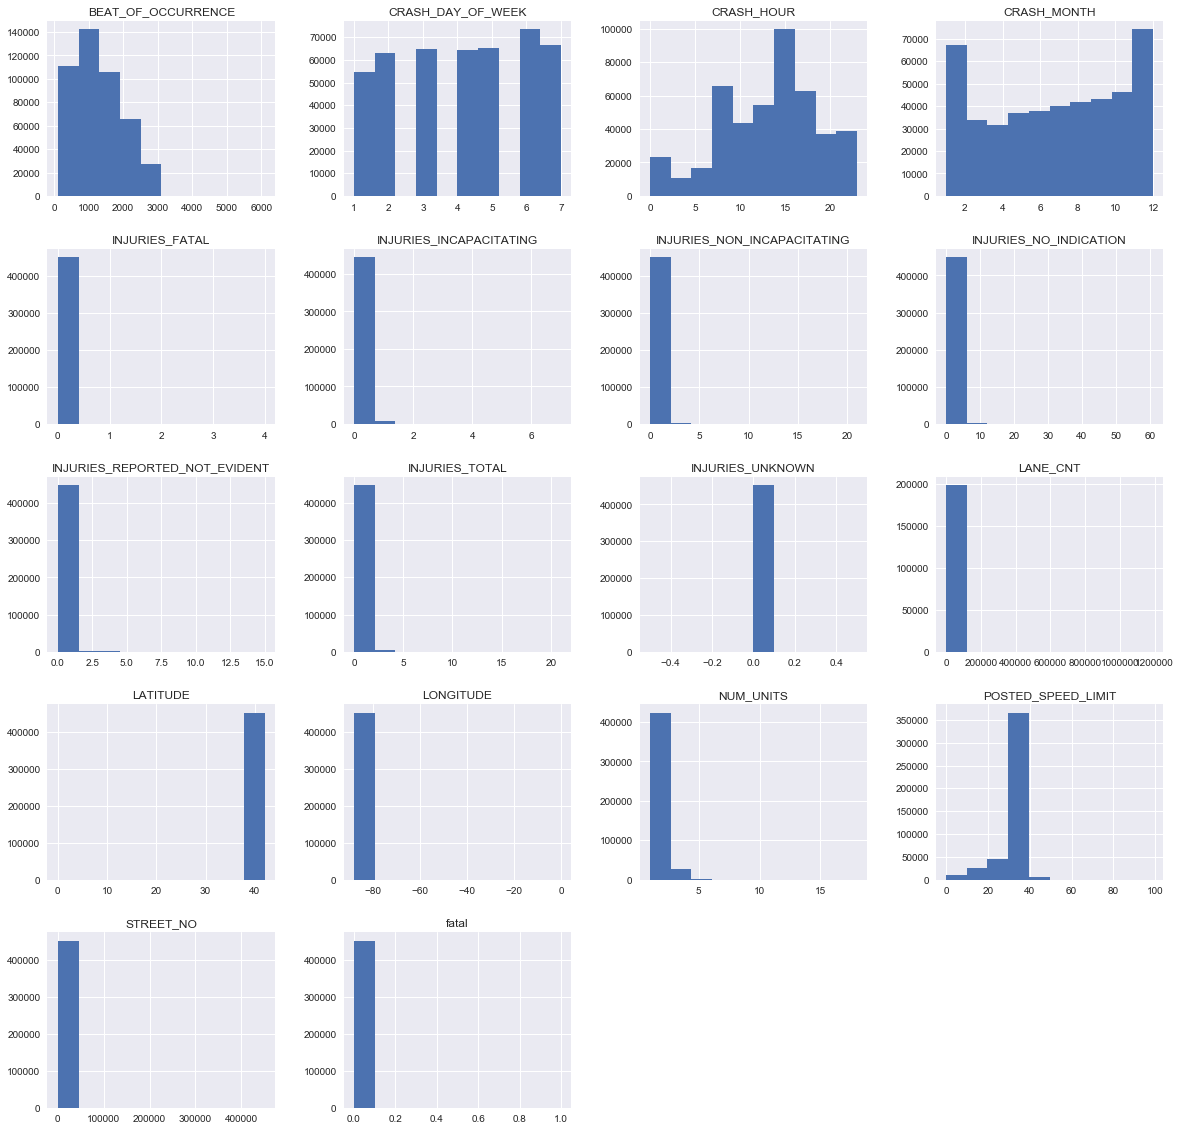

In [112]:
# df.hist(bins=10, figsize=(20,20))

## Plotting Geographical Data

In [119]:
# neigh_map = gpd.read_file('geo_export_aeab7300-7d09-4aec-ad13-b05f99ccc606.shp')
# crs = {'init': 'epsg:4326'}

In [134]:
# geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
# geometry[5:8]
# geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
# #geo_data = geo_df.dropna()
# geo_data = geo_data[geo_data.LATITUDE > 0]
# geo_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 452981 entries, 0 to 453872
Data columns (total 51 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   CRASH_RECORD_ID                452981 non-null  object  
 1   RD_NO                          449489 non-null  object  
 2   CRASH_DATE_EST_I               33566 non-null   object  
 3   CRASH_DATE                     452981 non-null  object  
 4   POSTED_SPEED_LIMIT             452981 non-null  int64   
 5   TRAFFIC_CONTROL_DEVICE         452981 non-null  object  
 6   DEVICE_CONDITION               452981 non-null  object  
 7   WEATHER_CONDITION              452981 non-null  object  
 8   LIGHTING_CONDITION             452981 non-null  object  
 9   FIRST_CRASH_TYPE               452981 non-null  object  
 10  TRAFFICWAY_TYPE                452981 non-null  object  
 11  LANE_CNT                       198607 non-null  float64 
 12  ALIGNMEN

/Users/rosegold/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
No handles with labels found to put in legend.


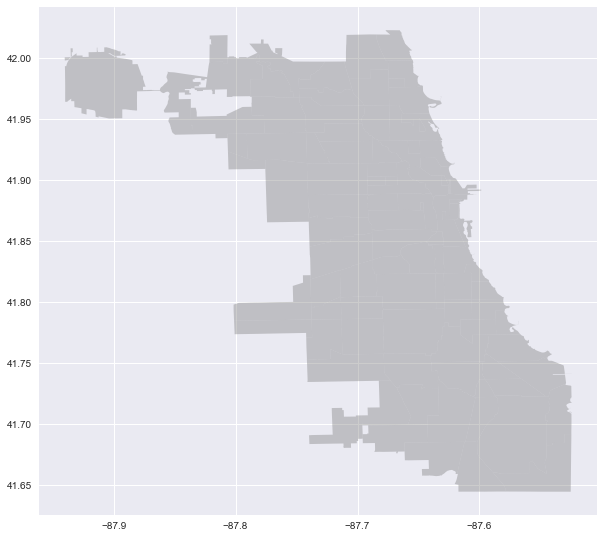

In [133]:
# #Plotting fatal injuries
# fig, ax = plt.subplots(figsize = (10,10))
# neigh_map.plot(ax = ax, alpha = 0.4, color='grey')
# geo_data[geo_data['fatal'] == 1].plot(ax = ax, markersize = 10, color='blue', marker='o', label = 'Fatal - 1 Person')
# #geo_data[geo_data['fatal'] == 2.0].plot(ax = ax, markersize = 10, color='red', marker='o', label = 'Fatal - 2 People')
# #geo_data[geo_data['fatal'] == 3.0].plot(ax = ax, markersize = 10, color='orange', marker='o', label = 'Fatal - 3 People')
# plt.legend(prop={'size': 10})

/Users/rosegold/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
No handles with labels found to put in legend.


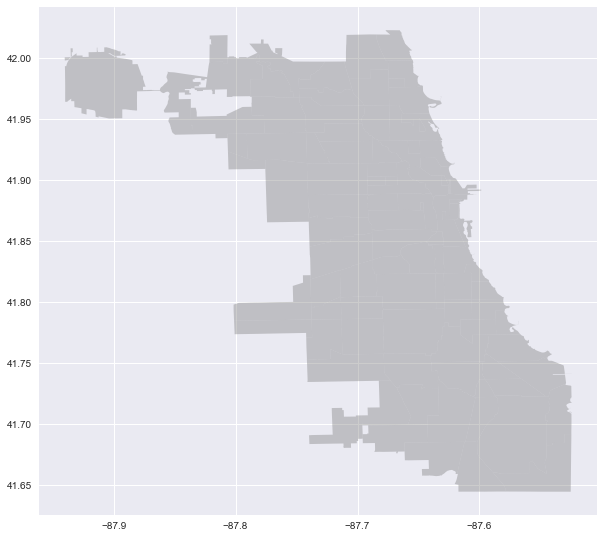

In [117]:
# #Plotting non-fatal but serious injuries
# fig, ax = plt.subplots(figsize = (10,10))
# neigh_map.plot(ax = ax, alpha = 0.4, color='grey')
# geo_data[geo_data['INJURIES_INCAPACITATING'] == 1.0].plot(ax = ax, markersize = 10, color='blue', marker='o', label = 'Non-Fatal Serious Injuries')
# plt.legend(prop={'size': 10})

/Users/rosegold/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
No handles with labels found to put in legend.


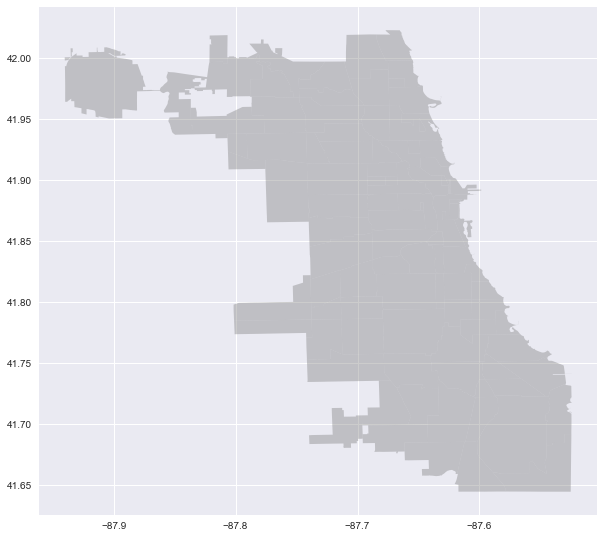

In [118]:
# #Plotting non-fatal and non-serious injuries
# fig, ax = plt.subplots(figsize = (10,10))
# neigh_map.plot(ax = ax, alpha = 0.4, color='grey')
# geo_data[geo_data['INJURIES_NON_INCAPACITATING'] == 1.0].plot(ax = ax, markersize = 10, color='blue', marker='o', label = 'Non-Fatal Non-Serious Injuries')
# plt.legend(prop={'size': 10})

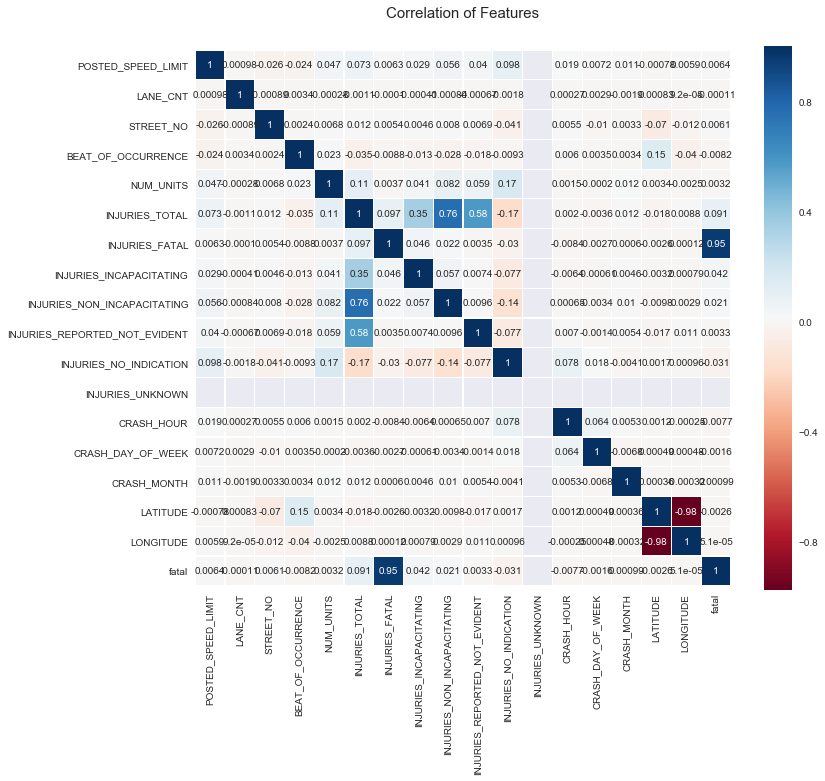

In [135]:
# colormap = plt.cm.RdBu
# plt.figure(figsize=(12,10))
# plt.title('Correlation of Features', y=1.05, size=15)
# sns.heatmap(df.corr(),
#             linewidths=0.1,
#             vmax=1.0, 
#             square=True, 
#             cmap=colormap, 
#             linecolor='white', 
#             annot=True)
# plt.show()

In [ ]:
# fatal = crashdata[crashdata['INJURIES_FATAL'] != 'UNKNOWN']
# #fatal = crashdata[crashdata['WEATHER_CONDITION'] != 'UNKNOWN']
# #fatal = crashdata[crashdata['LIGHTING_CONDITION'] != 'UNKNOWN']
# fatal = fatal.reset_index()

## One Hot Encoding

In [137]:
# ohe = OneHotEncoder(handle_unknown='ignore')

# weather = df['WEATHER_CONDITION']
# weather_df = pd.DataFrame(df, columns=['WEATHER_CONDITION'])
# weather_df = pd.DataFrame(ohe.fit_transform(weather_df[['WEATHER_CONDITION']]).toarray())

In [138]:
# weather_col = df['WEATHER_CONDITION'].unique()
# weather.columns = weather_col
# weather.columns

array(['CLEAR', 'RAIN', 'CLOUDY/OVERCAST', 'UNKNOWN', 'SNOW',
       'SLEET/HAIL', 'FOG/SMOKE/HAZE', 'FREEZING RAIN/DRIZZLE',
       'SEVERE CROSS WIND GATE', 'OTHER', 'BLOWING SNOW',
       'BLOWING SAND, SOIL, DIRT'], dtype=object)

## Label Encoding Features

In [139]:
text_col = ['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION','LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 
            'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'CRASH_HOUR','CRASH_DAY_OF_WEEK', 'CRASH_MONTH']
encode_df = pd.DataFrame()
for col in text_col:
    encoder = LabelEncoder()
    encode_df[col] = encoder.fit_transform(df[col])
    
encode_df

TRAFFIC_CONTROL_DEVICE  DEVICE_CONDITION  WEATHER_CONDITION  \
0                            4                 3                  2   
1                            4                 3                  2   
2                            4                 3                  2   
3                           15                 1                  2   
4                           16                 1                  2   
...                        ...               ...                ...   
452976                      15                 1                  2   
452977                       4                 3                  3   
452978                      15                 1                  2   
452979                       4                 3                  2   
452980                       4                 3                  2   

        LIGHTING_CONDITION  FIRST_CRASH_TYPE  TRAFFICWAY_TYPE  \
0                        0                 7               11   
1                        3                15               10   
2                        3                15               10   
3                        3                17                8   
4                        1                17                8   
...                    ...               ...              ...   
452976                   3                17                2   
452977                   3                17                3   
452978                   3                 3                2   
452979                   3                 7               10   
452980                   3                 7               10   

        ROADWAY_SURFACE_COND  CRASH_HOUR  CRASH_DAY_OF_WEEK  CRASH_MONTH  
0                          0          18                  2            9  
1                          0          16                  4            5  
2                          6          16                  4            1  
3                          0          16                  5            5  
4                          0          22                  4            2  
...                      ...         ...                ...          ...  
452976                     0           9                  2            6  
452977                     0          17                  3            6  
452978                     0          10                  3            6  
452979                     0          14                  3            6  
452980                     0           9                  3            6  

[452981 rows x 10 columns]

In [142]:
# Merge the two dataframes together
df2 = pd.merge(fatal, encode_df, left_index=True, right_index=True)

In [149]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452089 entries, 0 to 452980
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   fatal                   452089 non-null  int64
 1   TRAFFIC_CONTROL_DEVICE  452089 non-null  int64
 2   DEVICE_CONDITION        452089 non-null  int64
 3   WEATHER_CONDITION       452089 non-null  int64
 4   LIGHTING_CONDITION      452089 non-null  int64
 5   FIRST_CRASH_TYPE        452089 non-null  int64
 6   TRAFFICWAY_TYPE         452089 non-null  int64
 7   ROADWAY_SURFACE_COND    452089 non-null  int64
 8   CRASH_HOUR              452089 non-null  int64
 9   CRASH_DAY_OF_WEEK       452089 non-null  int64
 10  CRASH_MONTH             452089 non-null  int64
dtypes: int64(11)
memory usage: 41.4 MB


In [143]:
df2.columns

Index(['fatal', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH'],
      dtype='object')

## Train and Test Split

In [150]:
# Create features and labels
y = df2['fatal']
X = df2.drop(['fatal'], axis=1)

In [151]:
# Perform an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=10)

## Decision Tree Classifier

In [227]:
# Train a DT classifier
classifier = DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=10)  
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')

In [228]:
# Make predictions for test data
y_pred = classifier.predict(X_test) 

In [229]:
# Calculate accuracy 
acc = accuracy_score(y_test,y_pred) * 100
print('Accuracy of model fitted to test set is :{0}'.format(acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy of model fitted to test set is :51.56495388086443

AUC is :0.53

Confusion Matrix
----------------


Predicted      0      1    All
True                          
0          46574  43753  90327
1             41     50     91
All        46615  43803  90418

In [230]:
# Plot and show decision tree
plt.figure(figsize=(20,20), dpi=500)
tree.plot_tree(classifier, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

49.71% is not a very high accuracy score. I am going to try a different max depth to see if this raises the accuracy.

In [234]:
# Train a DT classifier
classifier_m = DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=10)  
classifier_m.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')

In [235]:
# Make predictions for test data
y_pred_m = classifier_m.predict(X_test) 

In [236]:
# Calculate accuracy 
acc = accuracy_score(y_test,y_pred_m) * 100
print('Accuracy of model fitted to test set is :{0}'.format(acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_m)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred_m, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy of model fitted to test set is :51.56495388086443

AUC is :0.53

Confusion Matrix
----------------


Predicted      0      1    All
True                          
0          46574  43753  90327
1             41     50     91
All        46615  43803  90418

In [237]:
# Plot and show decision tree
plt.figure(figsize=(20,20), dpi=500)
tree.plot_tree(classifier_m, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

## Features Importance

In [238]:
classifier.feature_importances_

array([0.0474023 , 0.11893779, 0.13419401, 0.02761941, 0.07363244,
       0.14826037, 0.06662577, 0.11480714, 0.08903728, 0.17948349])

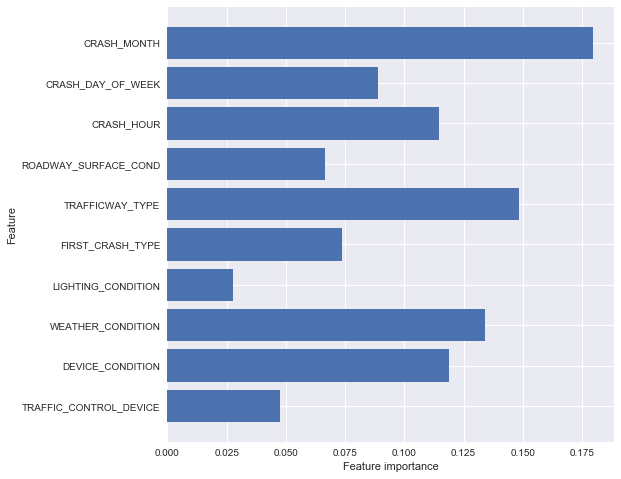

In [239]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(classifier)

## Decision Tree Using Entropy

In [222]:
# Instantiate and fit a DecisionTreeClassifier
classifier_2 = DecisionTreeClassifier(class_weight='balanced', random_state=10, criterion='entropy', max_depth=5)  
classifier_2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')

In [202]:
# Plot and show decision tree
plt.figure(figsize=(20,20), dpi=500)
tree.plot_tree(classifier_2, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

In [224]:
# Training accuracy score
classifier_2.score(X_train, y_train)

0.4977921923516124

In [225]:
# Test accuracy score
classifier_2.score(X_test, y_test)

0.49696962994094096

## Bag of Trees

Bagged Decision Trees train on slightly different training sets allowing for minor differences and slightly different predictions.

In [217]:
# Create a BaggingClassifier
bagtree =  BaggingClassifier(DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=10), 
                                 n_estimators=20)

In [218]:
# Fit to the training data
bagtree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=10,
                                                        splitter='best'),
   

In [219]:
# Training accuracy score
bagtree.score(X_train, y_train)

0.7949130563412604

In [220]:
# Test accuracy score
bagtree.score(X_test, y_test)

0.7936472826207172

## Random Forest Classifier

In [193]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(class_weight='balanced', n_estimators=100)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [195]:
# Training accuracy score
forest.score(X_train, y_train)

0.996870083584252

In [197]:
# Test accuracy score
forest.score(X_test, y_test)

0.9957862372536442

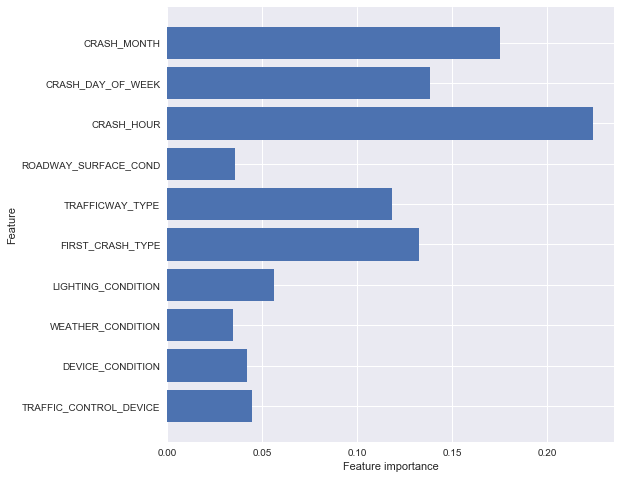

In [198]:
plot_feature_importances(forest)

## Hypertuning Parameters